In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf

import utils

/home/ifled/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
#SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
#WORK_DIRECTORY = 'data'
#IMAGE_SIZE = 28
#NUM_CHANNELS = 1
#PIXEL_DEPTH = 255
#NUM_LABELS = 10
#VALIDATION_SIZE = 5000  # Size of the validation set.
#SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64
NUM_EPOCHS = 200
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 100  # Number of steps between evaluations.
DATASET = 'cifar10'

NUM_UNROLL_STEPS = 5

### cifar 1

In [5]:
# took architecture from here: https://github.com/tensorflow/models/blob/f798e4b5504b0b7ed08f7b7a03fc5a79f00b9f21/tutorials/image/cifar10/cifar10.py#L188

def model_step(input_images, prior, batch_size, training, num_labels, use_priors):
    """The Model definition."""
    inputs = input_images
    
    conv1 = tf.layers.conv2d(
        inputs=inputs,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=2, padding='same')
    
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

    conv2 = tf.layers.conv2d(
        inputs=norm1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    
    pool2 = tf.layers.max_pooling2d(inputs=norm2, pool_size=[2, 2], strides=2, padding='same')
    
    pool2_shape = pool2.get_shape()
    num_units_after_conv = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]

    pool2_flat = tf.reshape(pool2, [-1, num_units_after_conv])
    
    if use_priors:
        projections = tf.layers.dense(inputs=prior, units=100, activation=tf.nn.relu)
        gates = tf.layers.dense(inputs=projections, units=num_units_after_conv, activation=tf.nn.sigmoid)
        
        gated = tf.multiply(pool2_flat, gates)
    else:
        gated = pool2_flat
    
    
    dense1 = tf.layers.dense(inputs=gated, units=384, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))
    
    dense2 = tf.layers.dense(inputs=dense1, units=192, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))

    logits = tf.layers.dense(inputs=dense2, units=num_labels)
    posteriors = tf.nn.softmax(logits)
    
    return logits, posteriors

def apply(input_images, training, train_labels_node, num_labels, use_priors):
    results = []
    loss = 0.0

    batch_size = input_images.get_shape()[0]
    priors = tf.ones((batch_size, num_labels)) / num_labels
    for step in range(NUM_UNROLL_STEPS):
        with tf.variable_scope('one_step', reuse=(step > 0)):
            logits, posteriors = model_step(input_images, priors, batch_size,
                                            training=training, num_labels=num_labels,
                                            use_priors=use_priors)
        priors = posteriors
        results.append((logits, posteriors))
        loss += tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=train_labels_node, logits=logits))
    return tf.stack([logits for (logits, _) in results]), loss

## Use priors = True

In [6]:
use_priors = True

tf.reset_default_graph()

dataset = utils.get_dataset(DATASET)

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=tf.float32)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
    1e-3,                # Base learning rate.
    batch * BATCH_SIZE,  # Current index into the dataset.
    dataset.train_size,          # Decay step.
    0.95,                # Decay rate.
    staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)

train_config = dict(
    optimizer=optimizer,
    batch_var=batch,
    learning_rate_var=learning_rate,
    train_batch_size=BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    eval_frequency=EVAL_FREQUENCY,
)

history, stdout_lines = utils.run_train(apply, train_config, dataset,
                                        build_func_kwargs=dict(use_priors=use_priors))

Initialized!
Step 0 (epoch 0.00), 39.2 ms
Minibatch loss: 11.124, learning rate: 0.001000
Minibatch error: [84.375, 84.375, 84.375, 84.375, 84.375]
Validation error: [90.28, 90.28, 90.28, 90.28, 90.28]
Step 100 (epoch 0.14), 125.3 ms
Minibatch loss: 8.062, learning rate: 0.001000
Minibatch error: [59.375, 60.9375, 60.9375, 60.9375, 60.9375]
Validation error: [57.04, 57.04, 57.04, 57.04, 57.04]
Step 200 (epoch 0.28), 125.3 ms
Minibatch loss: 7.018, learning rate: 0.001000
Minibatch error: [54.6875, 54.6875, 54.6875, 54.6875, 54.6875]
Validation error: [54.02, 53.96, 53.96, 53.98, 53.96]
Step 300 (epoch 0.43), 125.4 ms
Minibatch loss: 5.942, learning rate: 0.001000
Minibatch error: [40.625, 39.0625, 39.0625, 39.0625, 39.0625]
Validation error: [44.14, 44.12, 44.14, 44.14, 44.14]
Step 400 (epoch 0.57), 125.3 ms
Minibatch loss: 6.317, learning rate: 0.001000
Minibatch error: [40.625, 42.1875, 42.1875, 42.1875, 42.1875]
Validation error: [42.08, 41.84, 41.86, 41.86, 41.86]
Step 500 (epoch 0

Step 3700 (epoch 5.26), 125.4 ms
Minibatch loss: 0.998, learning rate: 0.000774
Minibatch error: [6.25, 6.25, 6.25, 6.25, 6.25]
Validation error: [29.260000000000005, 29.540000000000006, 29.379999999999995, 29.42, 29.42]
Step 3800 (epoch 5.40), 125.4 ms
Minibatch loss: 1.472, learning rate: 0.000774
Minibatch error: [9.375, 9.375, 9.375, 9.375, 9.375]
Validation error: [28.64, 28.64, 28.680000000000007, 28.599999999999994, 28.620000000000005]
Step 3900 (epoch 5.55), 125.4 ms
Minibatch loss: 0.681, learning rate: 0.000774
Minibatch error: [4.6875, 6.25, 6.25, 6.25, 6.25]
Validation error: [27.620000000000005, 27.560000000000002, 27.620000000000005, 27.599999999999994, 27.620000000000005]
Step 4000 (epoch 5.69), 125.5 ms
Minibatch loss: 0.835, learning rate: 0.000774
Minibatch error: [4.6875, 6.25, 6.25, 6.25, 6.25]
Validation error: [28.5, 28.260000000000005, 28.260000000000005, 28.239999999999995, 28.260000000000005]
Step 4100 (epoch 5.83), 125.6 ms
Minibatch loss: 0.881, learning rate

Step 7200 (epoch 10.24), 125.3 ms
Minibatch loss: 0.112, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.939999999999998, 26.819999999999993, 26.739999999999995, 26.739999999999995, 26.700000000000003]
Step 7300 (epoch 10.38), 125.2 ms
Minibatch loss: 0.155, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.879999999999995, 26.900000000000006, 26.819999999999993, 26.840000000000003, 26.819999999999993]
Step 7400 (epoch 10.52), 125.0 ms
Minibatch loss: 0.146, learning rate: 0.000599
Minibatch error: [1.5625, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [27.819999999999993, 27.64, 27.72, 27.64, 27.72]
Step 7500 (epoch 10.67), 124.8 ms
Minibatch loss: 0.137, learning rate: 0.000599
Minibatch error: [1.5625, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.58, 27.64, 27.540000000000006, 27.620000000000005, 27.58]
Step 7600 (epoch 10.81), 124.7 ms
Minibatch loss: 0.132, learning rate: 0.000599
Minibatch error: [0.

Step 10900 (epoch 15.50), 125.0 ms
Minibatch loss: 0.149, learning rate: 0.000463
Minibatch error: [1.5625, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [26.599999999999994, 26.540000000000006, 26.560000000000002, 26.540000000000006, 26.560000000000002]
Step 11000 (epoch 15.64), 125.2 ms
Minibatch loss: 0.031, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.060000000000002, 26.14, 26.180000000000007, 26.14, 26.14]
Step 11100 (epoch 15.79), 125.0 ms
Minibatch loss: 0.012, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.879999999999995, 25.739999999999995, 25.799999999999997, 25.799999999999997, 25.840000000000003]
Step 11200 (epoch 15.93), 125.3 ms
Minibatch loss: 0.040, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.319999999999993, 26.439999999999998, 26.28, 26.319999999999993, 26.239999999999995]
Step 11300 (epoch 16.07), 125.1 ms
Minibatch loss: 0.030, lea

Step 15600 (epoch 22.19), 125.1 ms
Minibatch loss: 0.046, learning rate: 0.000324
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.799999999999997, 25.560000000000002, 25.620000000000005, 25.599999999999994]
Step 15700 (epoch 22.33), 125.2 ms
Minibatch loss: 0.023, learning rate: 0.000324
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.040000000000006, 25.980000000000004, 26.040000000000006, 26.0, 26.040000000000006]
Step 15800 (epoch 22.47), 125.1 ms
Minibatch loss: 0.010, learning rate: 0.000324
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.340000000000003, 25.36, 25.42, 25.42, 25.459999999999994]
Step 15900 (epoch 22.61), 125.1 ms
Minibatch loss: 0.015, learning rate: 0.000324
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.939999999999998, 26.08, 26.099999999999994, 26.019999999999996, 26.060000000000002]
Step 16000 (epoch 22.76), 125.2 ms
Minibatch loss: 0.017, learning rate: 0.000324
Minibatc

Step 19400 (epoch 27.59), 125.1 ms
Minibatch loss: 0.002, learning rate: 0.000250
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.239999999999995, 25.379999999999995, 25.340000000000003, 25.379999999999995, 25.28]
Step 19500 (epoch 27.73), 125.1 ms
Minibatch loss: 0.005, learning rate: 0.000250
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.379999999999995, 25.200000000000003, 25.120000000000005, 25.120000000000005, 25.14]
Step 19600 (epoch 27.88), 125.1 ms
Minibatch loss: 0.004, learning rate: 0.000250
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.159999999999997, 25.120000000000005, 25.019999999999996, 25.060000000000002, 25.060000000000002]
Step 19700 (epoch 28.02), 125.0 ms
Minibatch loss: 0.022, learning rate: 0.000238
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.599999999999994, 26.659999999999997, 26.560000000000002, 26.599999999999994, 26.519999999999996]
Step 19800 (epoch 28.16), 125.2 ms
Minibatch loss:

Step 23100 (epoch 32.85), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000194
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.939999999999998, 23.980000000000004, 24.0, 24.019999999999996, 24.040000000000006]
Step 23200 (epoch 33.00), 125.3 ms
Minibatch loss: 0.001, learning rate: 0.000194
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.879999999999995, 24.959999999999994, 24.840000000000003, 24.900000000000006, 24.900000000000006]
Step 23300 (epoch 33.14), 125.2 ms
Minibatch loss: 0.001, learning rate: 0.000184
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.519999999999996, 25.659999999999997, 25.480000000000004, 25.58, 25.519999999999996]
Step 23400 (epoch 33.28), 125.1 ms
Minibatch loss: 0.006, learning rate: 0.000184
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.180000000000007, 25.299999999999997, 25.159999999999997, 25.22, 25.22]
Step 23500 (epoch 33.42), 125.1 ms
Minibatch loss: 0.020, learning rate: 0.00

Step 26800 (epoch 38.12), 124.9 ms
Minibatch loss: 0.000, learning rate: 0.000142
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.760000000000005, 23.819999999999993, 23.760000000000005, 23.799999999999997, 23.78]
Step 26900 (epoch 38.26), 124.9 ms
Minibatch loss: 0.000, learning rate: 0.000142
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.760000000000005, 23.760000000000005, 23.78, 23.78, 23.760000000000005]
Step 27000 (epoch 38.40), 125.0 ms
Minibatch loss: 0.000, learning rate: 0.000142
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.799999999999997, 23.78, 23.799999999999997, 23.760000000000005, 23.760000000000005]
Step 27100 (epoch 38.54), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000142
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.72, 23.879999999999995, 23.819999999999993, 23.819999999999993, 23.78]
Step 27200 (epoch 38.68), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000142
Minibatch error: [0.

Step 30500 (epoch 43.38), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.58, 23.599999999999994, 23.659999999999997, 23.64, 23.599999999999994]
Step 30600 (epoch 43.52), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.620000000000005, 23.620000000000005, 23.72, 23.700000000000003, 23.739999999999995]
Step 30700 (epoch 43.66), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.620000000000005, 23.659999999999997, 23.599999999999994, 23.659999999999997, 23.680000000000007]
Step 30800 (epoch 43.80), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.599999999999994, 23.700000000000003, 23.72, 23.739999999999995, 23.78]
Step 30900 (epoch 43.95), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibat

Step 34200 (epoch 48.64), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000085
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.560000000000002, 23.459999999999994, 23.42, 23.400000000000006, 23.480000000000004]
Step 34300 (epoch 48.78), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000085
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.58, 23.439999999999998, 23.400000000000006, 23.42, 23.5]
Step 34400 (epoch 48.92), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000085
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.560000000000002, 23.42, 23.459999999999994, 23.480000000000004, 23.519999999999996]
Step 34500 (epoch 49.07), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000081
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.72, 23.42, 23.5, 23.480000000000004, 23.480000000000004]
Step 34600 (epoch 49.21), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000081
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Valid

Step 37900 (epoch 53.90), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000066
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.42, 23.180000000000007, 23.22, 23.260000000000005, 23.319999999999993]
Step 38000 (epoch 54.04), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000063
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.319999999999993, 23.260000000000005, 23.319999999999993, 23.299999999999997, 23.379999999999995]
Step 38100 (epoch 54.19), 125.6 ms
Minibatch loss: 0.000, learning rate: 0.000063
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.439999999999998, 23.180000000000007, 23.299999999999997, 23.340000000000003, 23.36]
Step 38200 (epoch 54.33), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000063
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.400000000000006, 23.239999999999995, 23.299999999999997, 23.299999999999997, 23.319999999999993]
Step 38300 (epoch 54.47), 125.3 ms
Minibatch loss: 0.000, learn

Step 41500 (epoch 59.02), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.340000000000003, 23.22, 23.340000000000003, 23.36, 23.340000000000003]
Step 41600 (epoch 59.16), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.299999999999997, 23.22, 23.239999999999995, 23.299999999999997, 23.340000000000003]
Step 41700 (epoch 59.31), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.319999999999993, 23.22, 23.340000000000003, 23.28, 23.319999999999993]
Step 41800 (epoch 59.45), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.340000000000003, 23.260000000000005, 23.36, 23.299999999999997, 23.319999999999993]
Step 41900 (epoch 59.59), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.

Step 45200 (epoch 64.28), 125.0 ms
Minibatch loss: 0.000, learning rate: 0.000038
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.379999999999995, 23.22, 23.28, 23.22, 23.260000000000005]
Step 45300 (epoch 64.43), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000038
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.42, 23.299999999999997, 23.379999999999995, 23.319999999999993, 23.319999999999993]
Step 45400 (epoch 64.57), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000038
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.299999999999997, 23.319999999999993, 23.260000000000005, 23.22, 23.260000000000005]
Step 45500 (epoch 64.71), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000038
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.260000000000005, 23.260000000000005, 23.120000000000005, 23.159999999999997, 23.180000000000007]
Step 45600 (epoch 64.85), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000038
Minibat

Step 48800 (epoch 69.40), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000029
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.439999999999998, 23.36, 23.379999999999995, 23.400000000000006, 23.319999999999993]
Step 48900 (epoch 69.55), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000029
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.400000000000006, 23.36, 23.379999999999995, 23.400000000000006, 23.299999999999997]
Step 49000 (epoch 69.69), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000029
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.319999999999993, 23.299999999999997, 23.260000000000005, 23.260000000000005, 23.239999999999995]
Step 49100 (epoch 69.83), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000029
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.28, 23.319999999999993, 23.36, 23.319999999999993, 23.319999999999993]
Step 49200 (epoch 69.97), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.0

Step 52400 (epoch 74.52), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000022
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.540000000000006, 23.42, 23.379999999999995, 23.400000000000006, 23.340000000000003]
Step 52500 (epoch 74.67), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000022
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.620000000000005, 23.379999999999995, 23.400000000000006, 23.400000000000006, 23.379999999999995]
Step 52600 (epoch 74.81), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000022
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.439999999999998, 23.459999999999994, 23.42, 23.400000000000006]
Step 52700 (epoch 74.95), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000022
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.620000000000005, 23.439999999999998, 23.379999999999995, 23.400000000000006, 23.400000000000006]
Step 52800 (epoch 75.09), 125.2 ms
Minibatch loss:

Step 56100 (epoch 79.79), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.540000000000006, 23.480000000000004, 23.459999999999994, 23.459999999999994, 23.439999999999998]
Step 56200 (epoch 79.93), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.560000000000002, 23.42, 23.5, 23.459999999999994, 23.480000000000004]
Step 56300 (epoch 80.07), 125.6 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.599999999999994, 23.439999999999998, 23.439999999999998, 23.480000000000004, 23.42]
Step 56400 (epoch 80.21), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.560000000000002, 23.28, 23.36, 23.36, 23.379999999999995]
Step 56500 (epoch 80.36), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0

Step 59800 (epoch 85.05), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.599999999999994, 23.540000000000006, 23.540000000000006, 23.519999999999996, 23.519999999999996]
Step 59900 (epoch 85.19), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.58, 23.379999999999995, 23.42, 23.42, 23.42]
Step 60000 (epoch 85.33), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.64, 23.439999999999998, 23.42, 23.439999999999998, 23.439999999999998]
Step 60100 (epoch 85.48), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.58, 23.439999999999998, 23.459999999999994, 23.439999999999998, 23.439999999999998]
Step 60200 (epoch 85.62), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 

Step 63500 (epoch 90.31), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.659999999999997, 23.480000000000004, 23.459999999999994, 23.459999999999994, 23.519999999999996]
Step 63600 (epoch 90.45), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.680000000000007, 23.5, 23.480000000000004, 23.5, 23.480000000000004]
Step 63700 (epoch 90.60), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.659999999999997, 23.519999999999996, 23.480000000000004, 23.5, 23.5]
Step 63800 (epoch 90.74), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.659999999999997, 23.519999999999996, 23.519999999999996, 23.5, 23.459999999999994]
Step 63900 (epoch 90.88), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch er

Step 67300 (epoch 95.72), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.599999999999994, 23.519999999999996, 23.540000000000006, 23.560000000000002, 23.560000000000002]
Step 67400 (epoch 95.86), 125.0 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.659999999999997, 23.540000000000006, 23.519999999999996, 23.519999999999996, 23.540000000000006]
Step 67500 (epoch 96.00), 125.0 ms
Minibatch loss: 0.000, learning rate: 0.000007
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.659999999999997, 23.540000000000006, 23.519999999999996, 23.560000000000002, 23.519999999999996]
Step 67600 (epoch 96.14), 125.0 ms
Minibatch loss: 0.000, learning rate: 0.000007
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.659999999999997, 23.519999999999996, 23.560000000000002, 23.599999999999994, 23.58]
Step 67700 (epoch 96.28), 125.1 ms
Mi

Step 71000 (epoch 100.98), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.540000000000006, 23.599999999999994, 23.540000000000006, 23.540000000000006, 23.540000000000006]
Step 71100 (epoch 101.12), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.560000000000002, 23.599999999999994, 23.540000000000006, 23.540000000000006, 23.540000000000006]
Step 71200 (epoch 101.26), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.58, 23.560000000000002, 23.560000000000002, 23.560000000000002, 23.540000000000006]
Step 71300 (epoch 101.40), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.599999999999994, 23.540000000000006, 23.540000000000006, 23.5, 23.5]
Step 71400 (epoch 101.55), 125.0 ms
Minibatch loss: 0.000, le

Step 74500 (epoch 105.96), 125.7 ms
Minibatch loss: 0.000, learning rate: 0.000005
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.519999999999996, 23.58, 23.5, 23.560000000000002, 23.560000000000002]
Step 74600 (epoch 106.10), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000004
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.540000000000006, 23.5, 23.540000000000006, 23.540000000000006]
Step 74700 (epoch 106.24), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000004
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.519999999999996, 23.540000000000006, 23.5, 23.5]
Step 74800 (epoch 106.38), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000004
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.519999999999996, 23.540000000000006, 23.560000000000002, 23.540000000000006, 23.519999999999996]
Step 74900 (epoch 106.52), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000004
Minibatch error: [0.0, 0.0, 0.0, 0

Step 78100 (epoch 111.08), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.519999999999996, 23.540000000000006, 23.540000000000006, 23.540000000000006]
Step 78200 (epoch 111.22), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.519999999999996, 23.560000000000002, 23.519999999999996, 23.480000000000004]
Step 78300 (epoch 111.36), 125.6 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.519999999999996, 23.5, 23.560000000000002, 23.519999999999996, 23.519999999999996]
Step 78400 (epoch 111.50), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.519999999999996, 23.519999999999996, 23.560000000000002, 23.58]
Step 78500 (epoch 111.64), 125.4 ms
Minibatch loss: 0.000, learning rate: 0

Step 81800 (epoch 116.34), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.519999999999996, 23.5, 23.560000000000002, 23.540000000000006]
Step 81900 (epoch 116.48), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.5, 23.5, 23.58, 23.58]
Step 82000 (epoch 116.62), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.5, 23.480000000000004, 23.560000000000002, 23.599999999999994]
Step 82100 (epoch 116.76), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.480000000000004, 23.58, 23.599999999999994, 23.599999999999994]
Step 82200 (epoch 116.91), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000003
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.5, 

Step 85600 (epoch 121.74), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.5, 23.599999999999994, 23.620000000000005, 23.620000000000005]
Step 85700 (epoch 121.88), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.439999999999998, 23.519999999999996, 23.58, 23.620000000000005, 23.64]
Step 85800 (epoch 122.03), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.5, 23.560000000000002, 23.599999999999994, 23.620000000000005]
Step 85900 (epoch 122.17), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.5, 23.540000000000006, 23.599999999999994, 23.58]
Step 86000 (epoch 122.31), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [

Step 89200 (epoch 126.86), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000002
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.5, 23.599999999999994, 23.659999999999997, 23.64]
Step 89300 (epoch 127.00), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.519999999999996, 23.560000000000002, 23.599999999999994, 23.64]
Step 89400 (epoch 127.15), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.540000000000006, 23.560000000000002, 23.620000000000005, 23.64]
Step 89500 (epoch 127.29), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.540000000000006, 23.58, 23.620000000000005, 23.64]
Step 89600 (epoch 127.43), 125.6 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error:

Step 92900 (epoch 132.12), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.439999999999998, 23.560000000000002, 23.58, 23.64, 23.64]
Step 93000 (epoch 132.27), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.560000000000002, 23.58, 23.64, 23.64]
Step 93100 (epoch 132.41), 125.6 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.560000000000002, 23.599999999999994, 23.599999999999994, 23.599999999999994]
Step 93200 (epoch 132.55), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.439999999999998, 23.560000000000002, 23.560000000000002, 23.620000000000005, 23.64]
Step 93300 (epoch 132.69), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 

Step 96600 (epoch 137.39), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.439999999999998, 23.58, 23.58, 23.680000000000007, 23.64]
Step 96700 (epoch 137.53), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.560000000000002, 23.599999999999994, 23.64, 23.64]
Step 96800 (epoch 137.67), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.58, 23.599999999999994, 23.659999999999997, 23.659999999999997]
Step 96900 (epoch 137.81), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.58, 23.620000000000005, 23.680000000000007, 23.659999999999997]
Step 97000 (epoch 137.96), 125.6 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 

Step 100100 (epoch 142.36), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.439999999999998, 23.599999999999994, 23.599999999999994, 23.680000000000007, 23.659999999999997]
Step 100200 (epoch 142.51), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.58, 23.599999999999994, 23.680000000000007, 23.659999999999997]
Step 100300 (epoch 142.65), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.439999999999998, 23.599999999999994, 23.599999999999994, 23.680000000000007, 23.659999999999997]
Step 100400 (epoch 142.79), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.459999999999994, 23.599999999999994, 23.620000000000005, 23.680000000000007, 23.659999999999997]
Step 100500 (epoch 142.93), 1

Step 103600 (epoch 147.34), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.599999999999994, 23.64, 23.680000000000007, 23.659999999999997]
Step 103700 (epoch 147.48), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.599999999999994, 23.599999999999994, 23.680000000000007, 23.64]
Step 103800 (epoch 147.63), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.599999999999994, 23.599999999999994, 23.680000000000007, 23.64]
Step 103900 (epoch 147.77), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000001
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.599999999999994, 23.620000000000005, 23.680000000000007, 23.64]
Step 104000 (epoch 147.91), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.00000

Step 107200 (epoch 152.46), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.599999999999994, 23.599999999999994, 23.680000000000007, 23.64]
Step 107300 (epoch 152.60), 125.5 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.599999999999994, 23.620000000000005, 23.680000000000007, 23.64]
Step 107400 (epoch 152.75), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.620000000000005, 23.620000000000005, 23.680000000000007, 23.64]
Step 107500 (epoch 152.89), 125.6 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.599999999999994, 23.620000000000005, 23.680000000000007, 23.64]
Step 107600 (epoch 153.03), 125.5 ms
Minibatch loss: 0.000, learning

Step 110800 (epoch 157.58), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.620000000000005, 23.620000000000005, 23.680000000000007, 23.64]
Step 110900 (epoch 157.72), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.64, 23.620000000000005, 23.680000000000007, 23.64]
Step 111000 (epoch 157.87), 125.0 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.620000000000005, 23.620000000000005, 23.680000000000007, 23.64]
Step 111100 (epoch 158.01), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.64, 23.620000000000005, 23.680000000000007, 23.64]
Step 111200 (epoch 158.15), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch 

Step 114400 (epoch 162.70), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.620000000000005, 23.620000000000005, 23.680000000000007, 23.64]
Step 114500 (epoch 162.84), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.599999999999994, 23.620000000000005, 23.680000000000007, 23.64]
Step 114600 (epoch 162.99), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.599999999999994, 23.620000000000005, 23.680000000000007, 23.64]
Step 114700 (epoch 163.13), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.480000000000004, 23.599999999999994, 23.620000000000005, 23.680000000000007, 23.64]
Step 114800 (epoch 163.27), 125.2 ms
Minibatch loss: 0.000, learning

Step 118100 (epoch 167.96), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.620000000000005, 23.680000000000007, 23.64]
Step 118200 (epoch 168.11), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 118300 (epoch 168.25), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 118400 (epoch 168.39), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 118500 (epoch 168.53), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.62000000

Step 122000 (epoch 173.51), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 122100 (epoch 173.65), 125.0 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.620000000000005, 23.680000000000007, 23.64]
Step 122200 (epoch 173.80), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.620000000000005, 23.680000000000007, 23.64]
Step 122300 (epoch 173.94), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 122400 (epoch 174.08), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5

Step 126000 (epoch 179.20), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 126100 (epoch 179.34), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 126200 (epoch 179.48), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 126300 (epoch 179.63), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 126400 (epoch 179.77), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.6

Step 130000 (epoch 184.89), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 130100 (epoch 185.03), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 130200 (epoch 185.17), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 130300 (epoch 185.32), 125.4 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 130400 (epoch 185.46), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.6

Step 134000 (epoch 190.58), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 134100 (epoch 190.72), 125.1 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 134200 (epoch 190.86), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 134300 (epoch 191.00), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 134400 (epoch 191.15), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.6

Step 138000 (epoch 196.27), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 138100 (epoch 196.41), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 138200 (epoch 196.55), 125.3 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 138300 (epoch 196.69), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.64, 23.680000000000007, 23.64]
Step 138400 (epoch 196.84), 125.2 ms
Minibatch loss: 0.000, learning rate: 0.000000
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.5, 23.620000000000005, 23.6

In [7]:
test_error, train_metrics = history

In [9]:
losses, lrs, train_errors, val_erors = zip(*train_metrics)

In [10]:
from matplotlib import pyplot

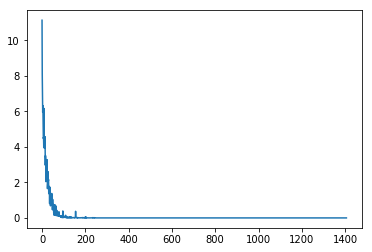

In [11]:
pyplot.plot(losses)

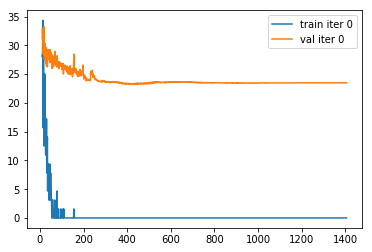

In [42]:
utils.plot_error_on_iterations(history, [10, None], [0], only_val=False)

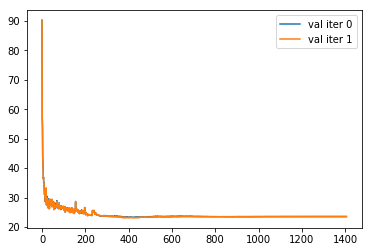

In [43]:
utils.plot_error_on_iterations(history, [None, None], [0, 1], only_val=True)

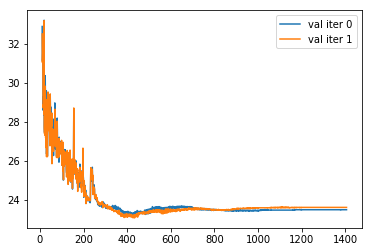

In [44]:
utils.plot_error_on_iterations(history, [10, None], [0, 1], only_val=True)

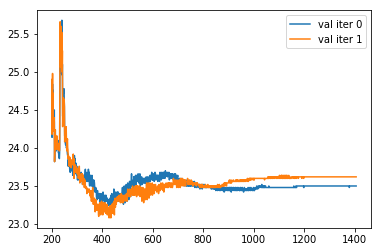

In [45]:
utils.plot_error_on_iterations(history, [200, None], [0, 1], only_val=True)

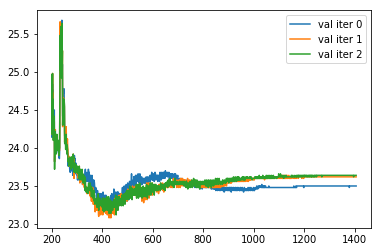

In [46]:
utils.plot_error_on_iterations(history, [200, None], [0, 1, 2], only_val=True)

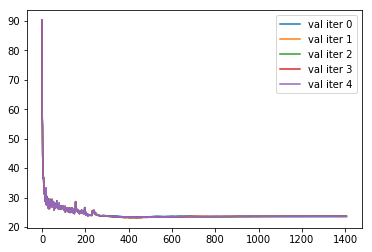

In [47]:
utils.plot_error_on_iterations(history, [None, None], [0, 1, 2, 3, 4], only_val=True)

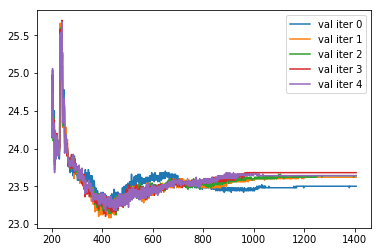

In [48]:
utils.plot_error_on_iterations(history, [200, None], [0, 1, 2, 3, 4], only_val=True)

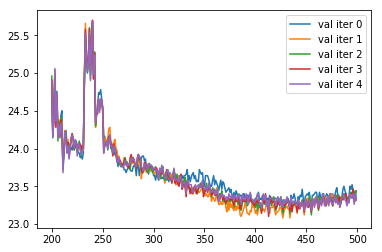

In [49]:
utils.plot_error_on_iterations(history, [200, 500], [0, 1, 2, 3, 4], only_val=True)

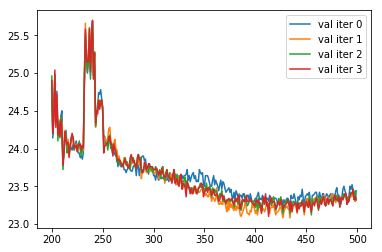

In [51]:
utils.plot_error_on_iterations(history, ranges=[200, 500], iterations=[0, 1, 2, 3], only_val=True)